In [61]:
import pandas as pd
import time
import gspread
from google.oauth2.service_account import Credentials
from gspread_dataframe import get_as_dataframe, set_with_dataframe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from sklearn.metrics import calinski_harabasz_score, make_scorer
from sklearn.model_selection import GridSearchCV
import warnings
from datetime import datetime, timedelta

warnings.filterwarnings("ignore")

In [11]:
scope = ['https://www.googleapis.com/auth/spreadsheets',
        'https://www.googleapis.com/auth/drive']

creds = Credentials.from_service_account_file("/work/cuenta de servicio.json", scopes=scope)
client = gspread.authorize(creds)

worksheet_data = client.open("SP_500_data_clean").get_worksheet(0).get_all_records()
worksheet = client.open("SP_500_data_clean").get_worksheet(0)

In [70]:
# El ticker BRK.B no se importa debido a su ausencía de datos y a su pertenencia al indice NYSE
df = get_as_dataframe(worksheet)
df.set_index("Date", inplace=True)
df.index = pd.to_datetime(df.index)
df = df.asfreq('D')
df.dropna(how="all", axis=0, inplace=True)
#df = df[["AAPL","MSFT","AMZN","TSLA","GOOGL","GOOG","NVDA","META","UNH"]]

In [71]:
df = df.pct_change()
df = df.iloc[1:,:]

In [74]:
df = df[-180:]

In [34]:
# importamos los datos prevaimente limpios y a los que les ha calculado el porcentaje de variación respecto al día haábil previo.
# si desea más información sobre como realizar este calculo en pandas sobre la data cruda puede revisar la función pandas.pct_change()
# df = pd.read_csv(r"C:\Users\maste\OneDrive\PDF\Maestria inteligencia Analitica de Datos\Aprendizaje no supervisado\sp500.csv")
# df = df.iloc[:,1:]
# df = pd.read_csv(r"C:\Users\maste\OneDrive\PDF\Maestria inteligencia Analitica de Datos\Aprendizaje no supervisado\total_symbols.csv")
# df = df.iloc[:,1:]
# df.dropna(how="any", axis=1, inplace=True)
# df = df.pct_change()
# df = df.iloc[1:,:]



In [75]:
df.shape

(180, 492)

In [15]:
from sklearn import covariance 

In [76]:
# Usaremos la sparse inverse covariance matrix para encontrar que variaciones de precio estan relacionadas condicionalmente con otras

model = covariance.GraphicalLassoCV(verbose=False)
X = df.copy()
X /= X.std(axis=0)

model.fit(X)

KeyboardInterrupt: 

In [0]:
emp_cov = np.dot(X.T, X) / len(df)
cv_ = model.covariance_


In [0]:
# comparando resultados para elección de GraphLassoCV
plt.figure(figsize=(20, 15))
plt.subplots_adjust(left=0.02, right=0.98)

# Graficando covarianzas
covs = [('Empirical', emp_cov),
        ('GraphicalLassoCV', cv_)]
vmax = cv_.max()
for i, (name, this_cov) in enumerate(covs):
    plt.subplot(2, 4, i + 1)
    plt.imshow(this_cov, interpolation='nearest', vmin=-vmax, vmax=vmax,
               cmap=plt.cm.RdBu_r)
    plt.xticks(())
    plt.yticks(())
    plt.title('%s covariance' % name)

In [0]:
# Seleccionado numero de alphas idoneo para el modelo
model.cv_results_["alphas"]

In [0]:
model.alpha_

In [0]:
# reentrenado modelo con alphas recalculados
model = covariance.GraphicalLassoCV(cv=10, verbose=False)
model.fit(X)

In [0]:
# esta matriz inversa de covarianza es la que será nuestro insumo para realizar el siguinete paso, la clusterización. Lo anterior debido a que con esta matriz tenemos el cálculo de los precios que se comportan de forma similar.
model.covariance_

In [23]:
from sklearn import cluster, covariance, manifold

In [43]:
def calinski_harabasz_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    score = calinski_harabasz_score(X, labels)
    return score

In [39]:
def afinity_tunning(data):

    # Instancia el modelo AffinityPropagation
    model = cluster.AffinityPropagation(random_state=42)

    # Parámetros para optimizar
    param_grid = {
        'preference': np.linspace(-50, -10, 10),
        'damping': np.linspace(0.5, 1, 6)
    }

    # Realiza la búsqueda de hiperparámetros
    grid_search = GridSearchCV(
        model, param_grid, scoring=make_scorer(calinski_harabasz_scorer, greater_is_better=True), cv=5
    )

        # Ajusta la búsqueda de hiperparámetros a los datos
    grid_search.fit(data)

    # Mejores hiperparámetros encontrados
    best_params = grid_search.best_params_

    return best_params

In [47]:
best_params = afinity_tunning(model.covariance_)

In [48]:
best_params

{'damping': 0.5, 'preference': -50.0}

In [49]:
#generando clusters
_, labels = cluster.affinity_propagation(model.covariance_, damping=best_params["damping"],preference=best_params["preference"])

In [50]:
#identificando clusters
n_labels = labels.max()
names=[]
for stock in df.columns.tolist():
    names.append(stock)
names = np.array(names)
for i in range(n_labels + 1):
    print('Cluster %i: %s' % ((i + 1), ', '.join(names[labels == i])))

Cluster 1: AAPL, MSFT, AMZN, TSLA, GOOGL, GOOG, NVDA, META, UNH


In [51]:
n = len(np.unique(labels))

In [52]:
# generando 2D anidado para propositos de visualización
posicion_nodo = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver='dense', n_neighbors=n)
anidado = posicion_nodo.fit_transform(X.T).T

(-0.5823743248739321, 0.42678926192902045)

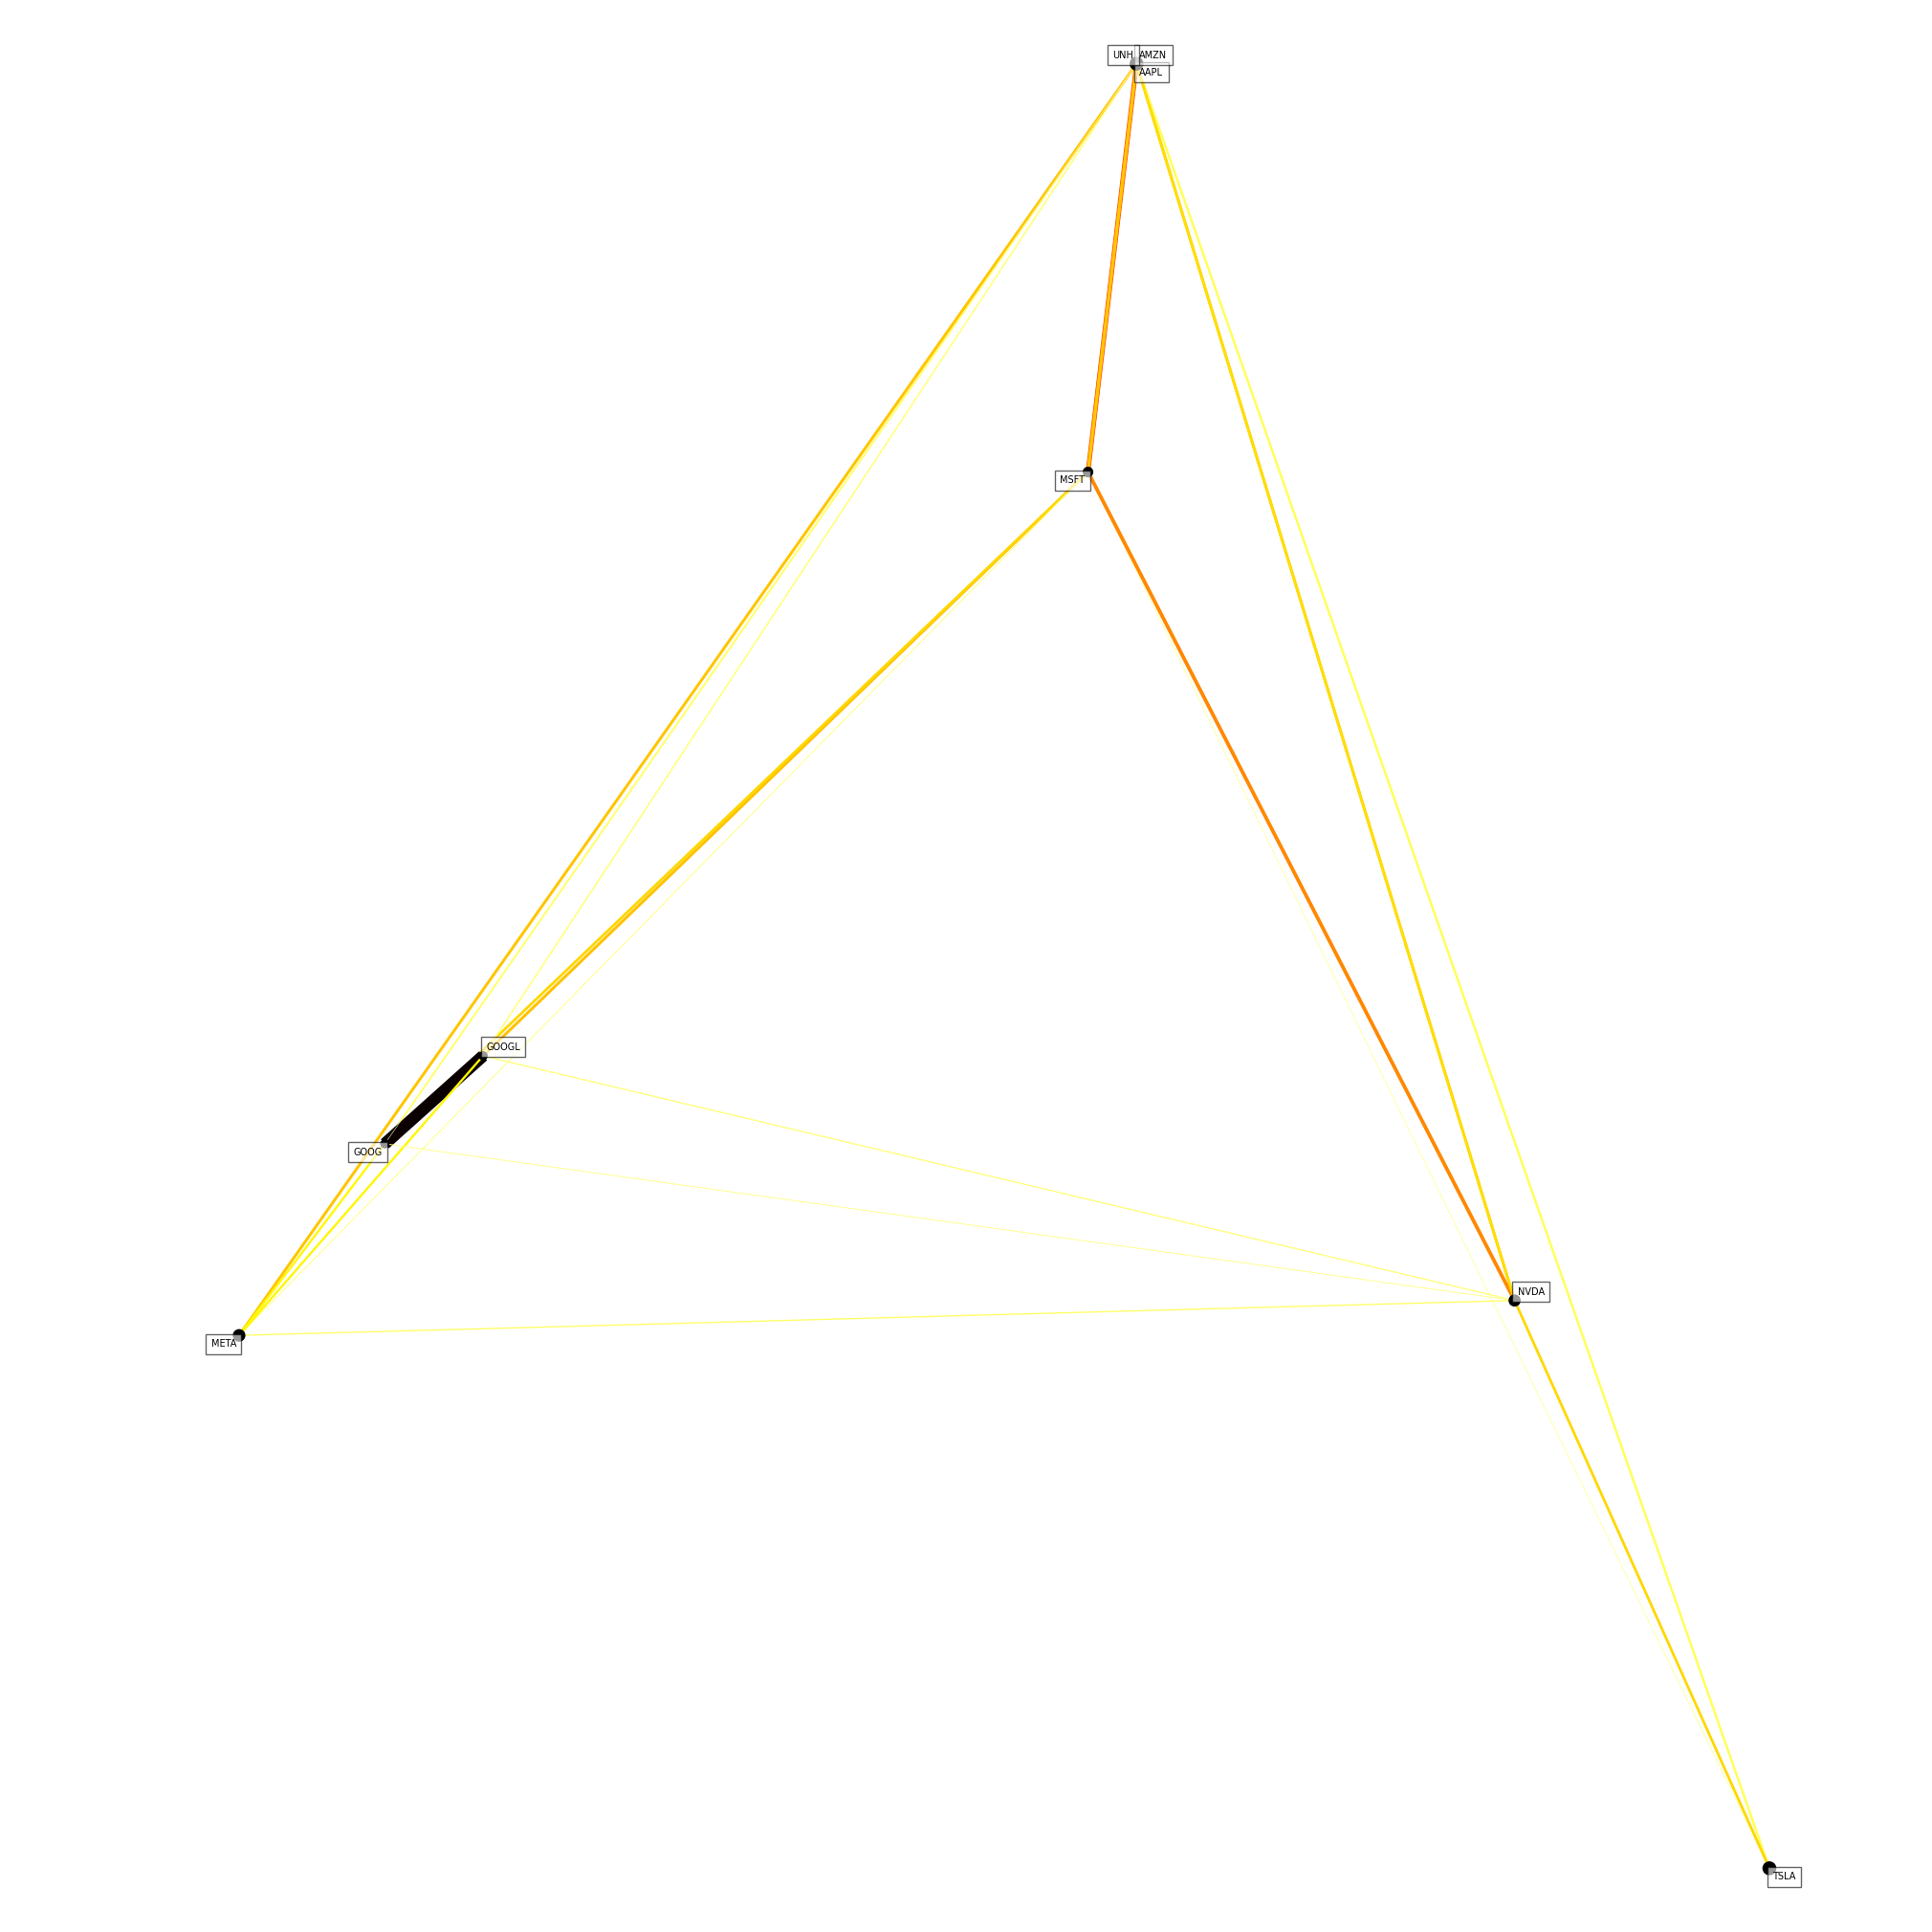

In [53]:
plt.figure(1, facecolor='w', figsize=(20, 20))
plt.clf()
ax = plt.axes([0., 0., 1., 1.])
plt.axis('off')

corr_parciales = model.precision_.copy()
d = 1 / np.sqrt(np.diag(corr_parciales))
corr_parciales *= d
corr_parciales *= d[:, np.newaxis]
non_zero = (np.abs(np.triu(corr_parciales, k=1)) > 0.02)
plt.scatter(anidado[0], anidado[1], s=100 * d ** 2, c=labels,
            cmap=plt.cm.nipy_spectral)

inicio_idx, fin_idx = np.where(non_zero)
segmentos = [[anidado[:, start], anidado[:, stop]]
            for start, stop in zip(inicio_idx, fin_idx)]
values = np.abs(corr_parciales[non_zero])
lc = LineCollection(segmentos,
                    zorder=0, cmap=plt.cm.hot_r,
                    norm=plt.Normalize(0, .7 * values.max()))
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

for indice, (name, label, (x, y)) in enumerate(
        zip(names, labels, anidado.T)):
    dx = x - anidado[0]
    dx[indice] = 1
    dy = y - anidado[1]
    dy[indice] = 1
    actual_dx = dx[np.argmin(np.abs(dy))]
    actual_dy = dy[np.argmin(np.abs(dx))]
    if actual_dx > 0:
        horizontalalignment = 'left'
        x = x + .002
    else:
        horizontalalignment = 'right'
        x = x - .002
    if actual_dy > 0:
        verticalalignment = 'bottom'
        y = y + .002
    else:
        verticalalignment = 'top'
        y = y - .002
    plt.text(x, y, name, size=7,
            horizontalalignment=horizontalalignment,
            verticalalignment=verticalalignment,
            bbox=dict(facecolor='w',
                    edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
                    alpha=.6))
plt.xlim(anidado[0].min() - .15 * anidado[0].ptp(),
        anidado[0].max() + .10 * anidado[0].ptp(),)
plt.ylim(anidado[1].min() - .03 * anidado[1].ptp(),
        anidado[1].max() + .03 * anidado[1].ptp())

El siguinete paso consistirá en generar el proceso de clusterización tomando como insumo esta matriz de covarianza o esta matriz de similitud de ambios en los precios de cierre.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8b6241ae-1445-4ce5-b5ef-fa423c12bbc0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>